<a href="https://colab.research.google.com/github/deltaori0/2020_Fall_ML/blob/master/wine_quality_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기계학습 기말 텀 프로젝트

작성자 : 2018320228 홍은수


## Task Description

Wine Quality Dataset을 사용하여 Classification/Clustering 모델을 생성 후 여러 기법들을 통해 최적의 모델을 찾고자 한다.

Section 1. Base Case 
- 데이터 전처리
- 파라미터 변경을 하지 않은 비교 기준이 되는 Base Classification Model 생성
- Clustering 결과 분석

Section 2. Feature Selection
- RFE 기법을 사용하여 Feature Selection 진행
- Feature Selection 적용한 Clustering 결과 분석

Section 3. Optimize Models
- Section 1과 2로부터 가장 성능이 좋은 모델 3가지를 골라 정확도 개선
- Cross-Validation 사용

Section 4. 최종 모델

Section 5. 결과 분석


## Data Description

[Wine Quality Prediction](https://www.kaggle.com/rajyellow46/wine-quality) 

Total number of instances  : 6497 개

Attributes (총 12 개)
- type

- fixed acidity

- volatile acidity

- citric acid

- residual sugar

- chlorides

- free sulfur dioxide

- total sulfur dioxide

- density

- pH

- sulphates

- alcohol

Class (총 1 개)
- quality (score between 0 and 10)
- quality class는 good(1)과 bad(0)를 나타내는 grade로 변경할 예정

## Section 1. Base Case

### 1. Pandas로 데이터 불러오기

In [ ]:
import pandas as pd

# 1. 데이터 불러오기
data_url = "https://raw.githubusercontent.com/deltaori0/2020_Fall_ML/master/winequalityN.csv"
df_wine = pd.read_csv(data_url)
df_wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### 2. 데이터 전처리

#### 데이터 타입 맞춰주기

In [ ]:
# 데이터 타입 확인
df_wine.dtypes

type                     object
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [ ]:
# object 타입을 category로 변경
df_wine['type'] = df_wine['type'].astype('category')
df_wine.dtypes

type                    category
fixed acidity            float64
volatile acidity         float64
citric acid              float64
residual sugar           float64
chlorides                float64
free sulfur dioxide      float64
total sulfur dioxide     float64
density                  float64
pH                       float64
sulphates                float64
alcohol                  float64
quality                    int64
dtype: object

#### 카테고리 데이터 정수로 인코딩

In [ ]:
df_wine['type'] = df_wine['type'].cat.codes

In [ ]:
df_wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


#### Missing Value 핸들링

데이터 분포를 보니 feature에 na 값이 있는 것을 확인할 수 있다. 이러한 행을 삭제한다.

In [ ]:
df_wine = df_wine.dropna()

df_wine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6463 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6463 non-null   int8   
 1   fixed acidity         6463 non-null   float64
 2   volatile acidity      6463 non-null   float64
 3   citric acid           6463 non-null   float64
 4   residual sugar        6463 non-null   float64
 5   chlorides             6463 non-null   float64
 6   free sulfur dioxide   6463 non-null   float64
 7   total sulfur dioxide  6463 non-null   float64
 8   density               6463 non-null   float64
 9   pH                    6463 non-null   float64
 10  sulphates             6463 non-null   float64
 11  alcohol               6463 non-null   float64
 12  quality               6463 non-null   int64  
dtypes: float64(11), int64(1), int8(1)
memory usage: 662.7 KB


In [ ]:
df_wine.isna().any()

type                    False
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool

#### Multivariate Class를 Binary 로 변환

In [ ]:
grade = [] 
for i in df_wine['quality']: 
    if i > 5:
        i = 1
        grade.append(i)
    else:
        i = 0
        grade.append(i)
df_wine['grade'] = grade 

In [ ]:
df_wine.drop('quality', axis = 1, inplace = True) 
df_wine.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,grade
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


#### Train -Test 나누기


In [ ]:
# 분류기에 넣을 feature와 label을 구분합니다.
X = df_wine.drop(columns=['grade'])
y = df_wine['grade']

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 

#### 정규화

MinMaxNormalization

In [ ]:
df_wine.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,grade
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,0.753520,7.217755,0.339589,0.318758,5.443958,0.056056,30.516865,115.694492,0.994698,3.218332,0.531150,10.492825,0.632988
std,0.430995,1.297913,0.164639,0.145252,4.756852,0.035076,17.758815,56.526736,0.003001,0.160650,0.148913,1.193128,0.482027
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992330,3.110000,0.430000,9.500000,0.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,1.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

### Base Model 설계

comparing with normalization results

#### 1) Naive Bayes

정규화 적용 전

In [ ]:
from sklearn.naive_bayes import CategoricalNB

naive_bayes = CategoricalNB()
naive_bayes.fit(X_train, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
naive_bayes.score(X_test, y_test)

0.6884992264053635

정규화 적용 후

In [ ]:
from sklearn.naive_bayes import CategoricalNB

naive_bayes_norm = CategoricalNB()
naive_bayes_norm.fit(X_train_norm, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
naive_bayes_norm.score(X_test_norm, y_test)

0.630737493553378

#### 2) Decision Tree

정규화 적용 전

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
decision_tree.score(X_test, y_test)

0.7591542031975245

정규화 적용 후

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_norm = DecisionTreeClassifier(random_state=42)
decision_tree_norm.fit(X_train_norm, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
decision_tree_norm.score(X_test_norm, y_test)

0.7581227436823105

#### 3) Logistic Regression

정규화 적용 전

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(max_iter=2000, random_state=42)
logistic_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logistic_reg.score(X_test, y_test)

0.7447137699845281

정규화 적용 후

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg_norm = LogisticRegression(max_iter=2000, random_state=42)
logistic_reg_norm.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logistic_reg_norm.score(X_test_norm, y_test)

0.7503867973182052

#### 4) Perceptron

정규화 적용 전

In [ ]:
from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=42)
perceptron.fit(X_train, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
perceptron.score(X_test, y_test)

0.6245487364620939

정규화 적용 후

In [ ]:
from sklearn.linear_model import Perceptron

perceptron_norm = Perceptron(random_state=42)
perceptron_norm.fit(X_train_norm, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
perceptron_norm.score(X_test_norm, y_test)

0.6988138215575038

#### 5) MLP

정규화 적용 전

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp.score(X_test, y_test)

0.7086126869520372

정규화 적용 후

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_norm = MLPClassifier(random_state=42)
mlp_norm.fit(X_train_norm, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp_norm.score(X_test_norm, y_test)

0.7643115007735947

#### 6) KNN

정규화 적용 전

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn.score(X_test, y_test)

0.6843733883445074

정규화 적용 후

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_norm = KNeighborsClassifier()
knn_norm.fit(X_train_norm, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_norm.score(X_test_norm, y_test)

0.7581227436823105

#### 7) Bagging 

Bagging with Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=5,
                            n_jobs=-1,
                            random_state=42)
bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [ ]:
bagging.score(X_test, y_test)

0.7947395564724085

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_norm = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=5,
                            n_jobs=-1,
                            random_state=42)
bagging_norm.fit(X_train_norm, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [ ]:
bagging_norm.score(X_test_norm, y_test)

0.7952552862300155

#### 8) Boosting

정규화 적용 전

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [ ]:
ada.score(X_test, y_test)

0.7529654461062403

정규화 적용 후

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_norm = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_norm.fit(X_train_norm, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [ ]:
ada_norm.score(X_test_norm, y_test)

0.7529654461062403

#### 9) Random Forest

정규화 적용 전

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5, random_state=42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
forest.score(X_test, y_test)

0.7859721505930892

정규화 적용 후

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_norm = RandomForestClassifier(n_estimators=5, random_state=42)
forest_norm.fit(X_train_norm, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
forest_norm.score(X_test_norm, y_test)

0.7849406910778752

#### 10) K-Means++

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42) 
kmeans.fit(X_train_norm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [ ]:
labels = kmeans.predict(X_train_norm)
print(labels)

[0 0 0 ... 1 1 0]


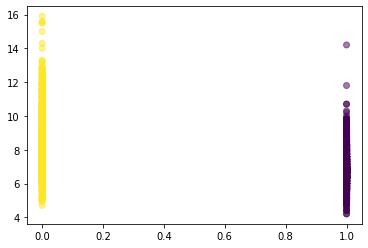

In [ ]:
import matplotlib.pyplot as plt

x = X_train.iloc[:, 0]  # 첫 번째 feature
y = X_train.iloc[:, 1]  # 두 번째 feature

plt.scatter(x, y, c=labels, alpha=0.5)
plt.show()

In [ ]:
#  k-means가 부여한 레이블과 실제 target값으로 DataFrame을 만든다
df = pd.DataFrame({'labels': labels, 'grade': y_train})
df

,labels,grade
4702,0,1
753,0,1
3754,0,1
5301,1,1
4922,1,1
...,...,...
3798,0,0
5219,1,0
5254,1,0
5418,1,1


In [ ]:
ct = pd.crosstab(df['labels'], df['grade'])
print(ct)

grade      0     1
labels            
0       1133  2275
1        517   599


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.33      0.69      0.45      1650
           1       0.54      0.21      0.30      2874

    accuracy                           0.38      4524
   macro avg       0.43      0.45      0.37      4524
weighted avg       0.46      0.38      0.35      4524



## Section 2. Feature Selection

### 반복적 특성 선택

Recursive Feature Elimination

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=11, step=1)
rfe.fit(X_train_norm, y_train)

RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=11, step=1, verbose=0)

In [ ]:
rfe.ranking_

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

([<matplotlib.axis.YTick at 0x7fe2034a7320>],
 <a list of 1 Text major ticklabel objects>)

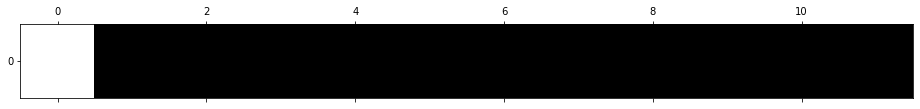

In [ ]:
# 선택된 특성 시각화
mask = rfe.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.yticks([0])

In [ ]:
X_train_fs = rfe.transform(X_train_norm)
X_test_fs = rfe.transform(X_test_norm)
print(X_train_norm.shape)
print(X_train_fs.shape) # feature selection을 통과한 것

(4524, 12)
(4524, 11)


### Feature Selection 모델 적용


##### 1) Naive Bayes

In [ ]:
from sklearn.naive_bayes import CategoricalNB

naive_bayes_fs = CategoricalNB()
naive_bayes_fs.fit(X_train_fs, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
naive_bayes_fs.score(X_test_fs, y_test)

0.630737493553378

#### 2) Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_fs = DecisionTreeClassifier(random_state=42)
decision_tree_fs.fit(X_train_fs, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
decision_tree_fs.score(X_test_fs, y_test)

0.7570912841670965

#### 3) Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg_fs = LogisticRegression(max_iter=2000, random_state=42)
logistic_reg_fs.fit(X_train_fs, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logistic_reg_fs.score(X_test_fs, y_test)

0.7488396080453842

#### 4) Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

perceptron_fs = Perceptron(random_state=42)
perceptron_fs.fit(X_train_fs, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=42, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
perceptron_fs.score(X_test_fs, y_test)

0.703971119133574

#### 5) MLP

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_fs = MLPClassifier(random_state=42)
mlp_fs.fit(X_train_fs, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
mlp_fs.score(X_test_fs, y_test)

0.7658586900464157

#### 6) KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_fs = KNeighborsClassifier()
knn_fs.fit(X_train_fs, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_fs.score(X_test_fs, y_test)

0.7570912841670965

#### 7) Bagging

Bagging with Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

bagging_fs = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=5,
                            n_jobs=-1,
                            random_state=42)
bagging_fs.fit(X_train_fs, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [ ]:
bagging_fs.score(X_test_fs, y_test)

0.7926766374419804

#### 8) Boosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_fs = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_fs.fit(X_train_fs, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=42)

In [ ]:
ada_fs.score(X_test_fs, y_test)

0.7529654461062403

#### 9) Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_fs = RandomForestClassifier(n_estimators=5, random_state=42)
forest_fs.fit(X_train_fs, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
forest_fs.score(X_test_fs, y_test)

0.7911294481691593

#### 10) K-Means++

In [ ]:
from sklearn.cluster import KMeans

kmeans_fs = KMeans(n_clusters=2) 
kmeans_fs.fit(X_train_fs)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
labels_fs = kmeans_fs.predict(X_train_fs)
print(labels_fs)

[1 0 0 ... 1 1 0]


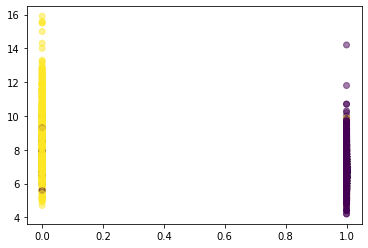

In [ ]:
import matplotlib.pyplot as plt

x = X_train.iloc[:, 0]
y = X_train.iloc[:, 1]

plt.scatter(x, y, c=labels_fs, alpha=0.5)
plt.show()

In [ ]:
#  k-means가 부여한 레이블과 실제 target값으로 DataFrame을 만듭니다.
df = pd.DataFrame({'labels': labels_fs, 'grade': y_train})
df

,labels,grade
4702,1,1
753,0,1
3754,0,1
5301,1,1
4922,1,1
...,...,...
3798,0,0
5219,1,0
5254,1,0
5418,1,1


In [ ]:
ct_fs = pd.crosstab(df['labels'], df['grade'])
print(ct_fs)

grade      0     1
labels            
0       1087  2266
1        563   608


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, labels))

              precision    recall  f1-score   support

           0       0.46      0.31      0.37      1650
           1       0.67      0.79      0.72      2874

    accuracy                           0.62      4524
   macro avg       0.57      0.55      0.55      4524
weighted avg       0.59      0.62      0.60      4524



## Section 3. Optimize Models

가장 성능이 좋았던 모델 세 개(MLP, Bagging, Random Forest)를 선택하여 매개변수를 변경해 가며 정확도 개선을 시도해 보도록 하겠다.

과적합(overfitting)을 방지하기 위해 cross validation을 이용하여 정확도 비교를 하고자 한다.

### 1) MLP

#### hidden_layer 개수 변경

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.neural_network import MLPClassifier
import numpy as np
from pprint import pprint

hidden_layer_list = [100, 110, 120, 130, 140, 150]
scores = []

for n in hidden_layer_list:
  print(n)
  skf = StratifiedKFold(n_splits=5) 
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(X_train_fs, y_train):
    X_train_cv, X_val_cv = X_train_fs[train_index], X_train_fs[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    mlp =  MLPClassifier(hidden_layer_sizes=n, max_iter=1000, random_state=42, early_stopping=True)

    mlp.fit(X_train_cv, y_train_cv)
    score = mlp.score(X_val_cv, y_val_cv)
    val_accuracy = np.append(val_accuracy, score)
  scores = np.append(scores, val_accuracy.mean())

pprint(scores)

100
110
120
130
140
150
array([0.72657092, 0.74049797, 0.7265719 , 0.72922407, 0.73519264,
       0.72635164])


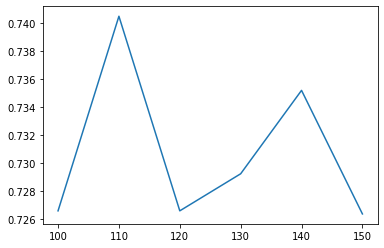

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hidden_layer_list, scores)

In [ ]:
hidden_layer_list[np.argmax(scores)]

110

In [ ]:
optimal_mlp =  MLPClassifier(hidden_layer_sizes=110, max_iter=1000, random_state=42, early_stopping=True)
optimal_mlp.fit(X_train_fs, y_train)
print(optimal_mlp.score(X_test_fs, y_test))

0.7488396080453842


### 2) Bagging

#### estimator 변경

DecisionTreeClassifier 대신 LogisticRegression과 KNN을 사용해 보도록 하겠다.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(LogisticRegression(), n_estimators= 5 , n_jobs=-1, random_state=42)
bagging.fit(X_train_fs, y_train)
print(bagging.score(X_test_fs, y_test))

0.7483238782877772


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(KNeighborsClassifier(), n_estimators= 5 , n_jobs=-1, random_state=42)
bagging.fit(X_train_fs, y_train)
print(bagging.score(X_test_fs, y_test))

0.7596699329551315


기존에 사용하던 DecisionTreeClassifier가 가장 최적이라는 것을 알 수 있다.

#### n_estimators 변경

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import numpy as np
from pprint import pprint

n_estimators_list = [5, 10, 20, 50, 70, 100, 120]
scores = []

for n in n_estimators_list:
  skf = StratifiedKFold(n_splits=5) 
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(X_train_fs, y_train):
    X_train_cv, X_val_cv = X_train_fs[train_index], X_train_fs[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators= n , n_jobs=-1, random_state=42)

    bagging.fit(X_train_cv, y_train_cv)
    score = bagging.score(X_val_cv, y_val_cv)
    val_accuracy = np.append(val_accuracy, score)
  scores = np.append(scores, val_accuracy.mean())

pprint(scores)

array([0.77983939, 0.79774165, 0.81034445, 0.81387792, 0.81542512,
       0.8174148 , 0.81807779])


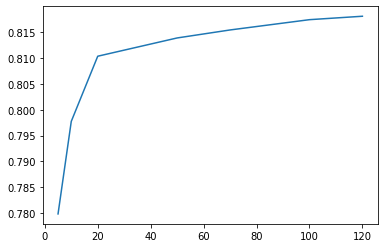

In [ ]:
import matplotlib.pyplot as plt

plt.plot(n_estimators_list, scores)

In [ ]:
n_estimators_list[np.argmax(scores)]

120

In [ ]:
optimal_bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators= 120 , n_jobs=-1, random_state=42)
optimal_bagging.fit(X_train_fs, y_train)
print(optimal_bagging.score(X_test_fs, y_test))

0.8241361526560083


### 3) Random Forest

#### n_estimators 변경

In [ ]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from pprint import pprint

n_estimators_list = [5, 10, 20, 50, 70, 100, 120]
scores = []

for n in n_estimators_list:
  skf = StratifiedKFold(n_splits=5) 
  val_accuracy = np.array([])
  for train_index, val_index in skf.split(X_train_fs, y_train):
    X_train_cv, X_val_cv = X_train_fs[train_index], X_train_fs[val_index]
    y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]

    forest =  RandomForestClassifier(n_estimators=n, random_state=42)

    forest.fit(X_train_cv, y_train_cv)
    score = forest.score(X_val_cv, y_val_cv)
    val_accuracy = np.append(val_accuracy, score)
  scores = np.append(scores, val_accuracy.mean())

pprint(scores)

array([0.78602699, 0.79796411, 0.81520559, 0.819404  , 0.81631105,
       0.81896372, 0.81940522])


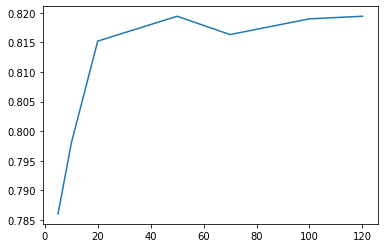

In [ ]:
import matplotlib.pyplot as plt

plt.plot(n_estimators_list, scores)

In [ ]:
n_estimators_list[np.argmax(scores)]

120

In [ ]:
optimal_forest =  RandomForestClassifier(n_estimators=120, random_state=42)
optimal_forest.fit(X_train_fs, y_train)
print(optimal_forest.score(X_test_fs, y_test))

0.813821557503868


#### criterion 변경

default: gini --> entropy

In [ ]:
forest =  RandomForestClassifier(criterion='entropy', n_estimators=120, random_state=42)
forest.fit(X_train_fs, y_train)
print(forest.score(X_test_fs, y_test))

0.8210417741103662


## Section 4. 최종 모델

가장 정확도가 높게 나온 Bagging을 최종 모델로 선정하였다.
- estimator : DecisionTreeClassifier
- n_estimators : 120

★ 최종 정확도 : 82.4%

## Section 5. 실험 설계 결과 분석

![models](https://user-images.githubusercontent.com/50616334/102675805-1f621980-41de-11eb-966f-bfd7ca0209f3.png)

### **Section 1**

이 섹션에서는 판다스 데이터를 불러오고 데이터 전처리 작업을 진행하였다. 사용한 데이터셋은 wine quality 데이터셋으로 총 13개의 attribute로 구성되어 있고 quality attribute를 class로 설정하였다. quality는 0~10까지의 점수로 매겨져 있는데 classification 모델을 구성할 때 분류 정확도를 좀 더 높이기 위해 binary class로 바꿔주었다. grade라는 새로운 class로 설정하여 quality가 5보다 크면 1, 작으면 0으로 만들어 주고 quality attribute는 삭제하였다. 데이터 셋을 살펴보니 Nan 값이 존재하여 이를 맞춰주었고 Train set과 Test set을 일반적으로 많이 사용하는 8:2 비율로 나누어 주었다. 또한 feature들의 범위가 다양하므로 Min Max Normalization을 통해 정규화 작업을 진행하여 base model을 설계할 때 정규화 하기 전 후를 비교하여 성능 차이를 알아보았다. 

최대한 다양한 모델을 비교해 보고자 9개의 classification 모델과 1개의 clustering 모델로 총 10개의 base model을 생성해 보았다. Naive Bayes Classifier와 Decision Tree Classifier을 제외한 모든 모델에서 정규화된 데이터를 사용했을 때 성능이 약간 더 좋아졌다. 또한 앙상블 기법을 쓴 모델(Bagging, Boosting, Random Forest)들이 다른 모델에 비해 성능이 좋게 나온 것을 확인해 볼 수 있었다. Base Case에서 Decision Tree Classifier를 사용한 Bagging이 79.5%의 정확도로 가장 높게 나왔고 그 다음 Random Forest 모델이 78.4% 정도의 정확도가 나왔다.


다음으로는 K-Means++ Clustering 결과를 분석해 보도록 하겠다.

![base_clustering](https://user-images.githubusercontent.com/50616334/102682363-53ecca00-420c-11eb-9512-a38cb800d15a.png)

2개의 군집으로 나눈 클러스터링을 해 보았는데 0 레이블은 1000개는 제대로 분류하고 500개는 제대로 분류를 못 한 것을 볼 수 있고 1 레이블은 제대로 분류가 되지 않는 것을 확인할 수 있었다.이는 데이터셋의 불균등성으로 인해 quality class가 5나 6에 편향되어 있어 binary class인 grade로 분류할 때 큰 차이가 없어 이러한 결과가 나온 것이라고 예상된다.

### **Section 2**

이 섹션에서는 RFE (Recursive Feature Elimination)을 사용하여 Feature Selection을 진행하였다. 그러나 초기 데이터셋의 feature들이 총 12개로 그렇게 많은 편은 아니라 n_features_to_select를 11로 하여 가장 관련이 없는 feature 하나만 제거하도록 설계하였고 정확도 향상이 크게 일어나지는 않았다. 처음 시도해 보았을 때는 초기 feature의 개수의 반인 6개의 feature만 선택하도록 하였는데 feature의 수가 너무 적어 정확도가 오히려 감소하는 현상이 발생해 너무 많은 feature를 제거하는 것도 좋지 않다는 것을 알게 되었다. 데이터셋의 feature의 수가 많을수록 feature selection이 효과가 더 크게 작용할 것으로 예상된다.

### **Section 3**

이 섹션에서는 최종 모델 선택을 위해 섹션 1, 2에서 성능이 가장 좋았던 3가지 모델인

- MLP : 76.5 %

- Bagging : 79.2 %

- Random Forest : 79.1 %

를 선택하여 파라미터를 변경해가며 최적화 작업을 진행했다. 

Test set으로 Validation을 진행하며 과적합(overfitting)이 발생할 수 있으므로 Cross Validation 기법으로 Stratified KFold를 사용하여 최적의 파라미터를 찾고자 하였다. . 

MLP의 경우에는 hidden layer의 개수를 변경해 가며 정확도를 비교해 보았다. 100, 110, 120, 130, 140, 150으로 cross validation을 돌려본 결과 110이 가장 정확도가 높게 나오는 것을 확인할 수 있었다. 다만, base model에서는 활성화하지 않았던 early stopping을 True로 설정해 과적합이 일어나는 것을 방지하고자 하였다. 따라서 Section 1에서 진행했을 때의 정확도인 76.5%에서 74.8%로 떨어졌지만 Section 1에서 높게 나온 이유는 과적합이 되었기 때문이라고 유추할 수 있었다.

Bagging의 경우에는 estimator와 n_estimators 두 가지 파라미터에 대해 값을 변경해 가며 비교해 보았다. estimator는 default가 Decision Tree Classifier이고 이번 섹션에서는 LogisticRegression과 KNN을 사용했을 때 정확도가 어떻게 달라지는지 확인해 보았다.
- Logistic Regression : 74.8 %
- KNN : 75.9 %

Decision Tree Classifier를 사용했을 때 79.2 %로 가장 높은 것을 확인하고 최종 estimator로 결정했다. 그 다음 파라미터로는 n_estimators를 바꿔가며 변화를 관찰해 보았다. 5, 10, 20, 50, 70, 100, 120를 cross validation을 통해 검증해 보았는데 120이 가장 정확도가 높게 나오는 것을 볼 수 있었다. 확실히 n_estimators가 높아지면 학습 속도는 오래 걸리지만 정확도가 높아졌다. 이를 통해 다양한 데이터 셋이 반영되기 때문에 과적합이 방지되어 variance가 낮아진다. 

Random Forest의 경우에는 n_estimators와 criterion을 변경해 보았다. Bagging과 마찬가지로 n_estimators는 클수록 성능이 대체로 더 좋아지는 것을 볼 수 있었고 따라서 최종으로 120을 선택하였다. criterion은 default인 gini에서 entropy로 바꾸어 보았더니 82.1%로 성능이 약간 개선되었다.


### **Section 4**

위의 과정들을 토대로 최적의 모델로 Test set의 정확도가 가장 높은 Decision Tree를 사용한 Bagging으로 결정하였다. 

**최종 정확도는 82.4%**로 Base Model의 79.4%와 비교하였을 때 대략 3% 정도의 정확도 향상을 이끌어 낼 수 있었다.

전체적으로 다양한 데이터셋을 사용하다 보니 앙상블 기법을 사용한 모델들의 성능이 뛰어나게 나오는 것을 볼 수 있었고 수업 시간에 배운 데이터 정규화나 다양한 기법들을 통해 정확도가 개선되는 것을 직접 실험해 볼 수 있어 의미 있는 프로젝트라고 생각한다.
